In [1]:
import re 
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras import Model

import tensorflow as tf
from keras import layers
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

2024-11-24 13:45:44.553648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv("/Users/jianhongxu/python_project/twitter_dataset/cleaned_tweet_9k.csv")
df.head()

,class,tweet
0,ADHD,people should always come before profits becau...
1,ADHD,last year was all over the news but not for th...
2,ADHD,today women want fairer representation in the ...
3,ADHD,we tend to focus on others instead of on ourse...
4,ADHD,firing employees over zoom is an extreme examp...


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jianhongxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def remove_number_stopwords(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    text = num.sub(r'',text)
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text
df['clean_tweet'] = df['tweet'].apply(remove_number_stopwords)

In [5]:
df.head(10)

,class,tweet,clean_tweet
0,ADHD,people should always come before profits becau...,people always come profits ultimately people c...
1,ADHD,last year was all over the news but not for th...,last year news right reasons learn httpurl htt...
2,ADHD,today women want fairer representation in the ...,today women want fairer representation upper r...
3,ADHD,we tend to focus on others instead of on ourse...,tend focus others instead truth sometimes take...
4,ADHD,firing employees over zoom is an extreme examp...,firing employees zoom extreme example shows im...
5,ADHD,thanks so much for having me it was a great di...,thanks much great discussion httpurl
6,ADHD,have you ever thought about what a toxic leade...,ever thought toxic leader organization toxic l...
7,ADHD,often people adapt to change because things ha...,often people adapt change things gone bad feel...
8,ADHD,after two years of the pandemic most employees...,two years pandemic employees demanding reality...
9,ADHD,last year fired employees on a zoom call which...,last year fired employees zoom call sent shock...


In [6]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df['labels'] = labelEncoder.fit_transform(df['class'])

df[['class','labels']].drop_duplicates(keep='first')

,class,labels
0,ADHD,0
2897,BIPOLAR,1
5771,DEPRESSION,2


In [7]:
train_text, test_text, train_label, test_label = train_test_split(df['clean_tweet'],df['labels'], 
                                                                  test_size=0.2,random_state=42)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweet'])

word_index = tokenizer.word_index
print(word_index)
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)
max_length = df['clean_tweet'].apply(lambda x:len(str(x).split())).max()
print(max_length)

{'httpurl': 1, 'people': 2, 'im': 3, 'work': 4, 'learn': 5, 'read': 6, 'dont': 7, 'get': 8, 'like': 9, 'one': 10, 'amp': 11, 'know': 12, 'need': 13, 'want': 14, 'leaders': 15, 'employee': 16, 'dailyscoop': 17, 'time': 18, 'employees': 19, 'experience': 20, 'things': 21, 'new': 22, 'make': 23, 'leader': 24, 'ceo': 25, 'think': 26, 'future': 27, 'take': 28, 'ive': 29, 'life': 30, 'says': 31, 'leadership': 32, 'today': 33, 'cant': 34, 'going': 35, 'see': 36, 'organization': 37, 'really': 38, 'according': 39, 'feel': 40, 'sponsored': 41, 'world': 42, 'fashionstyle': 43, 'technology': 44, 'youre': 45, 'years': 46, 'right': 47, 'even': 48, 'still': 49, 'way': 50, 'day': 51, 'great': 52, 'would': 53, 'us': 54, 'good': 55, 'never': 56, 'better': 57, 'isnt': 58, 'company': 59, 'every': 60, 'thing': 61, 'go': 62, 'something': 63, 'business': 64, 'help': 65, 'create': 66, 'three': 67, 'doesnt': 68, 'getting': 69, 'back': 70, 'others': 71, 'year': 72, 'important': 73, 'first': 74, 'change': 75, 'm

In [9]:
train_text = tokenizer.texts_to_sequences(train_text)
test_text = tokenizer.texts_to_sequences(test_text)

train_text = pad_sequences(train_text, maxlen=max_length)
test_text = pad_sequences(test_text, maxlen=max_length)

train_text.shape,test_text.shape

((6931, 33), (1733, 33))

In [10]:
train_label = pd.get_dummies(train_label, dtype=int)
test_label = pd.get_dummies(test_label, dtype=int)

train_label,test_label

(      0  1  2
 6205  0  0  1
 6516  0  0  1
 1414  1  0  0
 534   1  0  0
 5698  0  1  0
 ...  .. .. ..
 5734  0  1  0
 5191  0  1  0
 5390  0  1  0
 860   1  0  0
 7270  0  0  1
 
 [6931 rows x 3 columns],
       0  1  2
 1084  1  0  0
 2943  0  1  0
 4902  0  1  0
 1193  1  0  0
 921   1  0  0
 ...  .. .. ..
 8350  0  0  1
 6455  0  0  1
 7873  0  0  1
 5239  0  1  0
 107   1  0  0
 
 [1733 rows x 3 columns])

In [11]:
GLOVE_PATH = '/Users/jianhongxu/python_project/twitter_dataset/glove.6B.100d.txt'

embeddings_index = {}

f = open(GLOVE_PATH, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] =coefs
f.close()

print(f'Found {len(embeddings_index)} word vectors.')

EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [12]:
model = Sequential()
model.add(layers.Input(shape=(train_text.shape[1],)))
model.add(layers.Embedding(
    input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_length))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='swish'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 33, 100)        │     1,370,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 33, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,406,627 (5.37 MB)

 Trainable params: 1,406,627 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_text, train_label, epochs=10, verbose=1, 
                    validation_data=(test_text,test_label))

loss,accuracy = model.evaluate(train_text, train_label, verbose=0)
print(f'Training Accuracy: {accuracy:.4f}')
loss, accuracy = model.evaluate(test_text,test_label,verbose=0)
print(f"Testing Accuracy: {accuracy:.4f}")

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7135 - loss: 0.6990 - val_accuracy: 0.9417 - val_loss: 0.1719
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9421 - loss: 0.1831 - val_accuracy: 0.9602 - val_loss: 0.1261
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9638 - loss: 0.1133 - val_accuracy: 0.9660 - val_loss: 0.1160
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9715 - loss: 0.0870 - val_accuracy: 0.9711 - val_loss: 0.1039
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9773 - loss: 0.0643 - val_accuracy: 0.9723 - val_loss: 0.1156
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9879 - loss: 0.0381 - val_accuracy: 0.9671 - val_loss: 0.1267
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9876 - loss: 0.0404 - val_accuracy: 0.9723 - val_loss: 0.1195
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9888 - loss: 0.0368 - val_ac

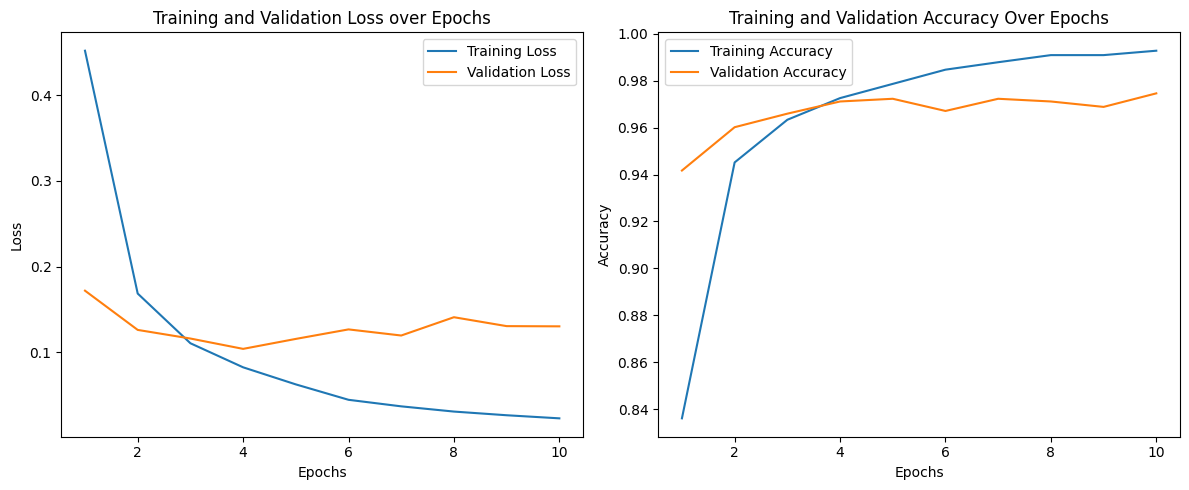

In [14]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, loss, label='Training Loss')
plt.plot(x, val_loss, label ='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, acc, label='Training Accuracy')
plt.plot(x, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


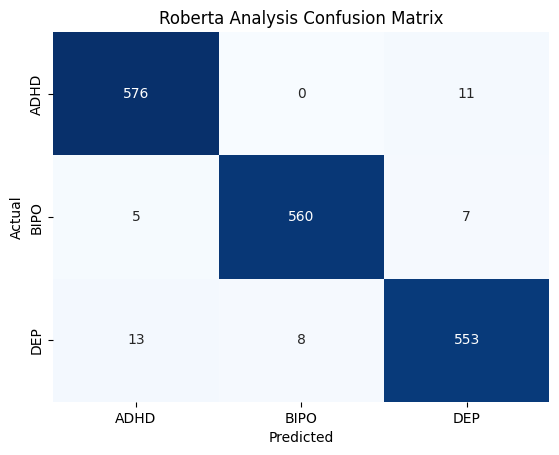

              precision    recall  f1-score   support

        ADHD       0.97      0.98      0.98       587
     BIPOLAR       0.99      0.98      0.98       572
  DEPRESSION       0.97      0.96      0.97       574

    accuracy                           0.97      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.97      0.97      0.97      1733



In [15]:
predict = model.predict(test_text)
predict = np.argmax(predict,axis=1)
predict = np.array(predict)

lables = test_label.idxmax(axis=1)

conf_matrix = confusion_matrix(lables, predict)
labels=["ADHD", "BIPO", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta Analysis Confusion Matrix')
plt.show()

print(classification_report(lables, predict, target_names=["ADHD", "BIPOLAR", "DEPRESSION"]))